In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functions_anisotropy import *

In [2]:
medium = load_medium_list()

#0 isotropic
#1 taylor sandstone
#2 mesaverde clayshale
#3 mesaverde laminated siltstone
#4 mesaverde mudshale
#5 mesaverde calcareous sandstone
#6 quartz


In [3]:
index = 1
C, density = get_specific_VTI(medium[index])

taylor sandstone
[[34.5974432   9.34087365 10.61386654  0.          0.          0.        ]
 [ 9.34087365 34.5974432  10.61386654  0.          0.          0.        ]
 [10.61386654 10.61386654 28.35856     0.          0.          0.        ]
 [ 0.          0.          0.          8.3631025   0.          0.        ]
 [ 0.          0.          0.          0.          8.3631025   0.        ]
 [ 0.          0.          0.          0.          0.         12.62828478]]


Noise-free traces


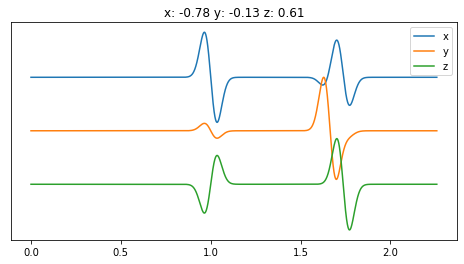

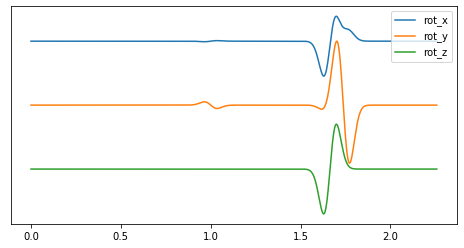

C:\Users\sebi\Anaconda3\envs\obspy\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


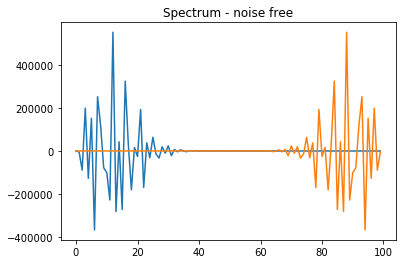

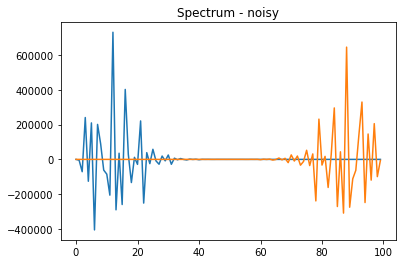

Noisy traces


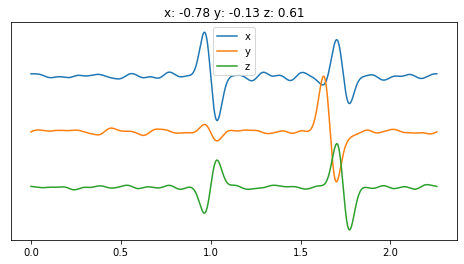

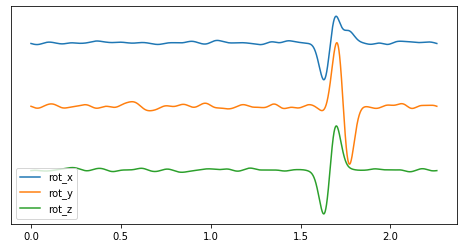

Misfit: 159.44737128355897
Max amplitude x-comp, noise free: 282.5535124507872
Max amplitude x-comp, noisy     : 285.7737350102088


In [4]:
f = 20.
amp = .2

### generating some traces
nus, gammas = get_direction('random',C,1)
vel,v = get_eigenvals(gammas[0], density)
seis, t = get_seis(v, vel, nus[0], f)

print('Noise-free traces')
plotseis(seis,t,nus[0])
seis_f = np.fft.fft(seis)
N=100  
#plot first N and last N components of fft
nt = len(seis[0,:])
plt.title('Spectrum - noise free')
plt.plot(range(0,N),seis_f[0,:N])
plt.plot(range(0,N),seis_f[0,nt-N:nt])
plt.show()

## this is where the noise happens
for i in range(0,6):
    seis_f[i,:] += seis_f[i,:]*amp*np.random.randn(len(seis_f[i,:]))
    
    
plt.title('Spectrum - noisy')
plt.plot(range(0,N),seis_f[0,:N])
plt.plot(range(0,N),seis_f[0,nt-N:nt])
plt.show()

seis_noisy = np.real(np.fft.ifft(seis_f))
print('Noisy traces')
plotseis(seis_noisy,t,nus[0])
misfit = 0
for k in range(0,6):
    amax = max(seis[k,:])
    for it in range(0,nt):
        misfit += ((seis_noisy[k,it]-seis[k,it])/amax)**2

print('Misfit: '+str(misfit))        
print('Max amplitude x-comp, noise free: '+str(max(seis[0,:])))
print('Max amplitude x-comp, noisy     : '+str(max(seis_noisy[0,:])))